# ConvNNM

Convolution nuclear norm minimization (ConvNNM) for traffic time series imputation.

In [1]:
import numpy as np

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def conv(vec, kernel_size):
    n = vec.shape[0]
    mat = np.zeros((n, kernel_size))
    mat[:, 0] = vec
    for k in range(1, kernel_size):
        mat[:, k] = np.append(vec[n - k :], vec[: n - k], axis = 0)
    return mat

def inv_conv(mat):
    kernel_size = mat.shape[1]
    vec = mat[:, 0]
    for k in range(1, kernel_size):
        vec += np.append(mat[k :, k], mat[: k, k], axis = 0)
    return vec / kernel_size

def svt(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - tau
    vec[vec < 0] = 0
    return u @ np.diag(vec) @ v

def ConvNNM(y_true, y, kernel_size, lmbda, maxiter = 50):
    eta = 100
    n = y.shape[0]
    pos_train = np.where(y != 0)
    pos_test = np.where((y_true != 0) & (y == 0))
    z = y.copy()
    Z = conv(z, kernel_size)
    W = np.zeros((n, kernel_size))
    show_iter = 100
    for it in range(maxiter):
        X = svt(Z - W * kernel_size / lmbda, kernel_size / lmbda)
        z = inv_conv(X + W * kernel_size / lmbda)
        z[pos_train] = (lmbda / (lmbda + eta) * z[pos_train]
                        + eta / (lmbda + eta) * y[pos_train])
        Z = conv(z, kernel_size)
        W = W + lmbda / kernel_size * (X - Z)
        y_hat = inv_conv(X)
        if (it + 1) % show_iter == 0:
            print(it + 1)
            print(compute_mape(y_true[pos_test], y_hat[pos_test]))
            print(compute_rmse(y_true[pos_test], y_hat[pos_test]))
            print()
    return y_hat

**Evaluate the empirical time complexity**: First generating data of Length $2^{10},2^{11},\ldots,x^{20}$.

In [2]:
import numpy as np
np.random.seed(1)
import time

t = 0
repeat = 50
time_mat = np.zeros((11, repeat))
for power in range(10, 21, 1):
    print('Power = {}'.format(power))
    T = 2 ** power
    y = np.random.randn(T)
    kernel_size = 2 ** 4
    lmbda = 5e-3 * T
    for i in range(repeat):
        start = time.time() * 1000
        x = ConvNNM(y, y, kernel_size, lmbda)
        end = time.time() * 1000
        time_mat[t, i] = end - start
        print('Running time: %d milliseconds.'%(time_mat[t, i]))
        print()
    t += 1

Power = 10
Running time: 45 milliseconds.

Running time: 24 milliseconds.

Running time: 18 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds.

Running time: 17 milliseconds

#### Draw Empirical Time Complexity

In [3]:
import numpy as np

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def laplacian(n, tau):
    ell = np.zeros(n)
    ell[0] = 2 * tau
    for k in range(tau):
        ell[k + 1] = -1
        ell[-k - 1] = -1
    return ell

def prox(z, w, lmbda, denominator):
    T = z.shape[0]
    temp1 = np.fft.fft(lmbda * z - w) / denominator
    temp2 = 1 - T / (denominator * np.abs(temp1))
    temp2[temp2 <= 0] = 0
    return np.fft.ifft(temp1 * temp2).real

def update_z(y_train, pos_train, x, w, lmbda, eta):
    z = x + w / lmbda
    z[pos_train] = (lmbda / (lmbda + eta) * z[pos_train] 
                    + eta / (lmbda + eta) * y_train)
    return z

def update_w(x, z, w, lmbda):
    return w + lmbda * (x - z)

def LCR(y_true, y, lmbda, gamma, tau, maxiter = 50):
    eta = 100 * lmbda
    T = y.shape
    pos_train = np.where(y != 0)
    y_train = y[pos_train]
    pos_test = np.where((y_true != 0) & (y == 0))
    y_test = y_true[pos_test]
    z = y.copy()
    w = y.copy()
    ell = np.fft.fft(laplacian(T, tau))
    denominator = lmbda + gamma * np.abs(ell) ** 2
    del y_true, y
    show_iter = 100
    for it in range(maxiter):
        x = prox(z, w, lmbda, denominator)
        z = update_z(y_train, pos_train, x, w, lmbda, eta)
        w = update_w(x, z, w, lmbda)
        if (it + 1) % show_iter == 0:
            print(it + 1)
            print(compute_mape(y_test, x[pos_test]))
            print(compute_rmse(y_test, x[pos_test]))
            print()
    return x

import numpy as np
np.random.seed(1)
import time

tau = 2
t = 0
repeat = 50
time_mat1 = np.zeros((11, repeat))
for power in range(10, 21, 1):
    print('Power = {}'.format(power))
    T = 2 ** power
    y = np.random.randn(T)
    lmbda = 5e-3 * T
    gamma = 2 * lmbda
    for i in range(repeat):
        start = time.time() * 1000
        x = LCR(y, y, lmbda, gamma, tau)
        end = time.time() * 1000
        time_mat1[t, i] = end - start
        print('Running time: %d milliseconds.'%(time_mat1[t, i]))
        print()
    t += 1

Power = 10
Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 5 milliseconds.

Running time: 5 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds.

Running time: 1 milliseconds

Empirical time complexity of LCR. The model is tested 50 times on each generated data.

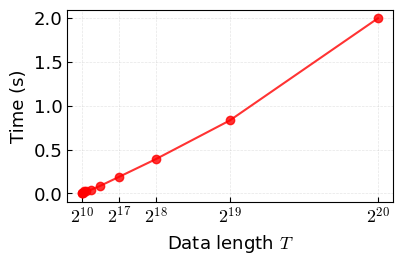

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.fontset'] = 'cm'

fig = plt.figure(figsize = (4.2, 2.5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(np.array([2**10, 2**11, 2**12, 2**13, 2**14, 2**15,
                   2**16, 2**17, 2**18, 2**19, 2**20]), 
         np.mean(time_mat1, axis = 1) / 1000, '-o', color = 'r', alpha = 0.8)

plt.xlabel(r'Data length $T$')
plt.ylabel('Time (s)')
labels = [r'$2^{10}$', r'$2^{17}$',
          r'$2^{18}$', r'$2^{19}$', r'$2^{20}$']
plt.xticks(np.array([2**10, 2**17, 2**18, 2**19, 2**20]), labels)
ax.tick_params(which = 'minor', direction ='in')
ax.grid(color = 'gray', linestyle = 'dashed', linewidth = 0.5, alpha = 0.2)
plt.show()
# fig.savefig("empirical_time_complexity_curve_linear.pdf", bbox_inches = "tight")#### Draw Empirical Time Complexity

Empirical time complexity of ConvNNM and LCR. The model is tested 50 times on each generated data.

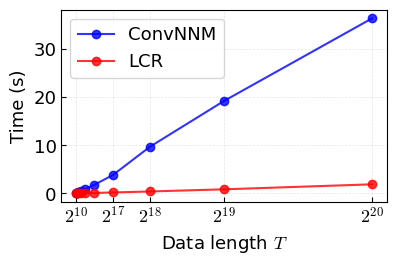

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.fontset'] = 'cm'

fig = plt.figure(figsize = (4.2, 2.5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(np.array([2**10, 2**11, 2**12, 2**13, 2**14, 2**15,
                   2**16, 2**17, 2**18, 2**19, 2**20]),
         np.mean(time_mat, axis = 1) / 1000, '-o', color = 'blue', alpha = 0.8)
plt.plot(np.array([2**10, 2**11, 2**12, 2**13, 2**14, 2**15,
                   2**16, 2**17, 2**18, 2**19, 2**20]),
         np.mean(time_mat1, axis = 1) / 1000, '-o', color = 'red', alpha = 0.8)
plt.legend(['ConvNNM', 'LCR'])
plt.xlabel(r'Data length $T$')
plt.ylabel('Time (s)')
labels = [r'$2^{10}$', r'$2^{17}$',
          r'$2^{18}$', r'$2^{19}$', r'$2^{20}$']
plt.xticks(np.array([2**10, 2**17, 2**18, 2**19, 2**20]), labels)
ax.tick_params(which = 'minor', direction = 'in')
ax.grid(color = 'gray', linestyle = 'dashed', linewidth = 0.5, alpha = 0.2)
plt.show()
# fig.savefig("empirical_time_complexity_curve_convnnm_vs_lcr_linear.pdf", bbox_inches = "tight")#### Draw Empirical Time Complexity

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>